<a href="https://colab.research.google.com/github/George7531/for_machine_learning/blob/main/ml/Learnings/deep_learning_tool_kits/Pytorch/tamil_letter_recognition_amity_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the essential Libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
import os,zipfile, requests
from PIL import Image

# Downloading the modular packages from GitHub to run our model

In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
# making the program device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Collect images of handwritten letters of one of the Indian languages (Tamil Language we choose.)

In [4]:
!kaggle datasets download -d gauravduttakiit/tamil-handwritten-character-recognition

Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/tamil-handwritten-character-recognition
License(s): CC0-1.0
 99% 47.0M/47.4M [00:04<00:00, 18.6MB/s]
100% 47.4M/47.4M [00:04<00:00, 11.2MB/s]


In [5]:
data_path = Path('data')

image_path = data_path / 'images'

image_path.mkdir(parents=True,exist_ok=True)

with zipfile.ZipFile(Path('tamil-handwritten-character-recognition.zip'),'r') as zip:
  zip.extractall(image_path)
  zip.close()

# keeping only the first 10 classes in each train and test directories to reduce computation cost

In [6]:
import os

train_dir = "data/images/train"
test_dir = "data/images/test"


for directory in os.listdir(train_dir):
  if int(directory) > 9:  # Assuming directory names are numbers (modify if needed)
    # Delete files within the directory
    for filename in os.listdir(os.path.join(train_dir, directory)):
      os.remove(os.path.join(train_dir, directory, filename))
    # Now remove the empty directory
    os.rmdir(os.path.join(train_dir, directory))

for directory in os.listdir(test_dir):
  if int(directory) > 9:
    # Delete files within the directory (similar logic as train_dir)
    for filename in os.listdir(os.path.join(test_dir, directory)):
      os.remove(os.path.join(test_dir, directory, filename))
    os.rmdir(os.path.join(test_dir, directory))

### exploration,ablation-anlysis and freethrows

In [ ]:
os.listdir('data/images/train')[:10]

['9', '5', '8', '7', '4', '1', '3', '2', '6', '0']

# data analysis

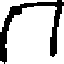

In [7]:
image = Image.open('data/images/test/0/1332.bmp')
image

In [ ]:
image.size

(64, 64)

I hope all images are of same size.

In [8]:
image = Image.open('data/images/test/103/14682.bmp')
image

FileNotFoundError: [Errno 2] No such file or directory: 'data/images/test/103/14682.bmp'

In [ ]:
image.size

(64, 64)

# Use dimension reduction techniques, PCA and t-SNE to reduce the dimensions of the data

`we don't have to do any dimensionality reduction such as PCA or t-SNE on these images since they are all already Grey-scaled (lack color dimension) and of only 64*64 pixels. Reducing the pixels further would only make the images blurry and unrecognizable which may lead to poor prediction.`

# Creating a classification model using Support Vector Machines method:

## our goal:

1. Load and preprocess the images.
2. Extract features from the images.
3. Create labels corresponding to the directories.
4. Train the SVC model using the extracted features and labels.

In [9]:
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Reading in grayscale
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize to a fixed size (optional)
            images.append(img)
    return images

def extract_features(images):
    features = []
    for img in images:
        hog = cv2.HOGDescriptor(_winSize=(64,64), _blockSize=(16, 16), _blockStride=(8, 8),
                        _cellSize=(8, 8), _nbins=9)
        h = hog.compute(img)
        features.append(h.flatten())
    return features

def prepare_data(base_path):
    X = []
    y = []
    class_labels = sorted(os.listdir(base_path))

    for label in class_labels:
        folder_path = os.path.join(base_path, label)
        if os.path.isdir(folder_path):
            images = load_images_from_folder(folder_path)
            features = extract_features(images)
            X.extend(features)
            y.extend([int(label)] * len(features))

    return np.array(X), np.array(y)



In [25]:
# Paths to our training and testing directories
train_dir = 'data/images/train'
test_dir = 'data/images/test'

# Prepare training and testing data
X_train, y_train = prepare_data(train_dir)
X_test, y_test = prepare_data(test_dir)



In [11]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04094693],
       [0.29188234, 0.07262876, 0.21733242, ..., 0.        , 0.        ,
        0.05268452],
       [0.        , 0.        , 0.        , ..., 0.01220999, 0.00408038,
        0.16795866],
       ...,
       [0.00520518, 0.0245234 , 0.07338312, ..., 0.        , 0.        ,
        0.01159594],
       [0.10746498, 0.3550737 , 0.3550737 , ..., 0.        , 0.        ,
        0.01932   ],
       [0.04595582, 0.1369119 , 0.32789975, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [12]:
y_train

array([0, 0, 0, ..., 9, 9, 9])

In [13]:
len(y_train)

3210

In [14]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
# Create a pipeline with standard scaling and SVC
clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Train the SVC model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.98


conclusion: 98% of accuracy is pretty impressive for the base model

In [16]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay


cm = confusion_matrix(y_test,y_pred)

cm

array([[75,  0,  0,  0,  2,  0,  0,  4,  0,  0],
       [ 0, 80,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 80,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 80,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0, 77,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 80,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 80,  0,  0,  0],
       [ 6,  0,  0,  0,  0,  0,  0, 74,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 80,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 80]])

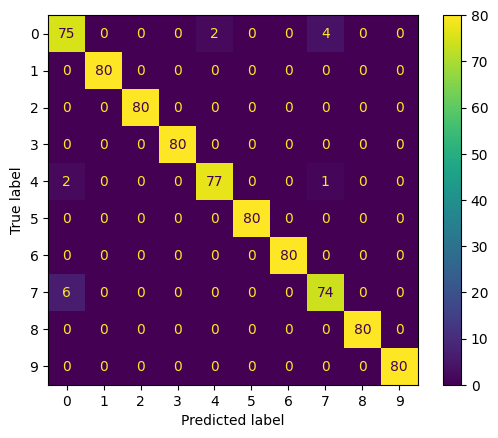

In [17]:
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test)
plt.show()

In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        81
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        80
           4       0.97      0.96      0.97        80
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00        80
           7       0.94      0.93      0.93        80
           8       1.00      1.00      1.00        80
           9       1.00      1.00      1.00        80

    accuracy                           0.98       801
   macro avg       0.98      0.98      0.98       801
weighted avg       0.98      0.98      0.98       801



* f1-scores are all good
* average of f1-score of 0.98(98% of predictive accuracy) is pretty impressive given that it is just a base model and we have not done the fine-tuining yet!


## validate the model on the test data

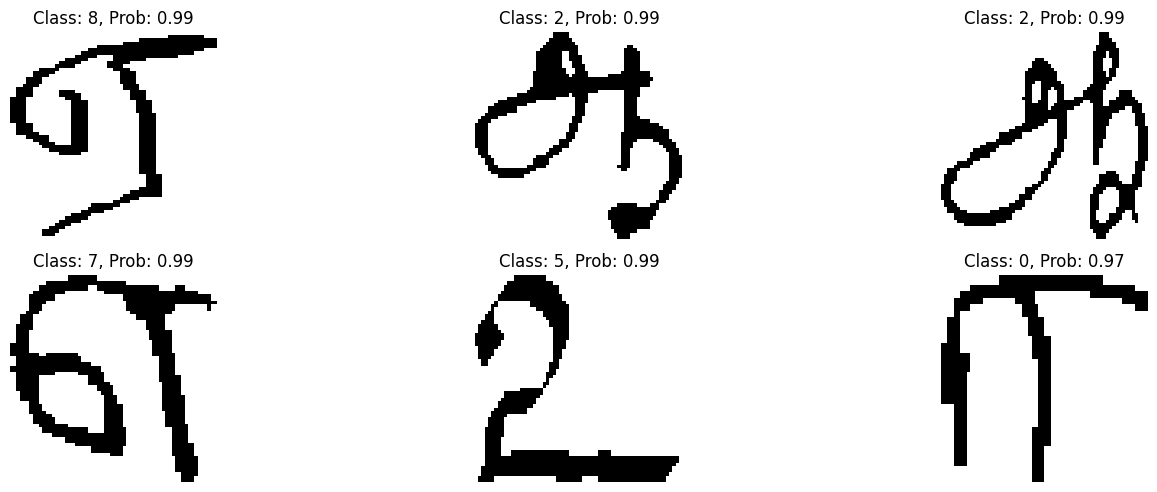

In [19]:
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.calibration import CalibratedClassifierCV

# Calibrate the SVC model to get probability estimates
calibrated_clf = CalibratedClassifierCV(clf, cv='prefit')
calibrated_clf.fit(X_train, y_train)

# Function to load a single image given its path
def load_single_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))  # Resize to match the HOG descriptor size
    return img

# Get the list of test images and their corresponding paths
test_images_paths = []
test_labels = []
for label in sorted(os.listdir(test_dir)):
    label_path = os.path.join(test_dir, label)
    for filename in os.listdir(label_path):
        test_images_paths.append(os.path.join(label_path, filename))
        test_labels.append(int(label))

# Randomly select a few test images
num_images = 6  # Number of images to display
indices = random.sample(range(len(test_images_paths)), num_images)

# Prepare the subplot
fig, axes = plt.subplots(2, 3, figsize=(16, 5))
axes = axes.ravel()

for i, idx in enumerate(indices):
    img_path = test_images_paths[idx]
    img = load_single_image(img_path)
    true_class = test_labels[idx]

    # Extract HOG features for the selected image
    hog = cv2.HOGDescriptor(_winSize=(64, 64), _blockSize=(16, 16), _blockStride=(8, 8),
                            _cellSize=(8, 8), _nbins=9)
    h = hog.compute(img).flatten().reshape(1, -1)

    # Predict the class and probability
    probas = calibrated_clf.predict_proba(h)[0]
    pred_class = np.argmax(probas)
    pred_prob = probas[pred_class]

    # Display the image
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Class: {pred_class}, Prob: {pred_prob:.2f}")
    axes[i].axis('off')

plt.tight_layout(pad=1)
plt.show()


In [ ]:
indices

[275, 83, 281, 25, 137, 711]

In [20]:
X_test[275]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.04958795], dtype=float32)

## fine-tuning the model

In [23]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [27]:
from sklearn.model_selection import train_test_split
import optuna


# Define the objective function for Optuna
def objective(trial):
    # Suggest values of the hyperparameters
    C = trial.suggest_float('C', 1e-3, 1e3)
    gamma = trial.suggest_float('gamma', 1e-4, 1e0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])

    # Create a pipeline with standard scaling and SVC
    pipeline = make_pipeline(StandardScaler(), SVC(C=C, gamma=gamma, kernel=kernel))

    # Train the SVC model
    pipeline.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Print the best parameters and the best score
print(f'Best parameters found: {study.best_params}')
print(f'Best cross-validation score: {study.best_value:.2f}')

# Train the best model on the entire training set and evaluate on the test set
best_params = study.best_params
best_pipeline = make_pipeline(StandardScaler(), SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel']))
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

[I 2024-06-03 05:58:29,040] A new study created in memory with name: no-name-1190a55b-55ca-4585-aab7-10fc814c7990
[I 2024-06-03 05:58:31,090] Trial 0 finished with value: 0.9812734082397003 and parameters: {'C': 222.60015190177626, 'gamma': 0.4143359726135204, 'kernel': 'linear'}. Best is trial 0 with value: 0.9812734082397003.
[I 2024-06-03 05:58:32,997] Trial 1 finished with value: 0.9812734082397003 and parameters: {'C': 158.20957627925597, 'gamma': 0.8842376592977027, 'kernel': 'linear'}. Best is trial 0 with value: 0.9812734082397003.
[I 2024-06-03 05:58:51,157] Trial 2 finished with value: 0.10112359550561797 and parameters: {'C': 960.201296694589, 'gamma': 0.42900568177259085, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9812734082397003.
[I 2024-06-03 05:59:10,035] Trial 3 finished with value: 0.10112359550561797 and parameters: {'C': 109.18410715284499, 'gamma': 0.20773613764745852, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9812734082397003.
[I 2024-06-03 05:59:12,204

Best parameters found: {'C': 222.60015190177626, 'gamma': 0.4143359726135204, 'kernel': 'linear'}
Best cross-validation score: 0.98
Test Accuracy: 0.98


## conclusion:

* The best model seems to give the same test accuracy as the base model which is 98% perhaps we should have run more trials.

# Creating a classification model using neural networks

## creating the dataloader:
Batch the images for faster computation.

## why automatic transform?

* when we manually create all the transform functions we may mistakenly morph the data into the form that is not similar to the kind of data the the pretrained model that we download from internet was trained on, automatic transform takes care of this issue for us.
* this transform function normalizes all images in the concerned data to be alike(hence the name 'normalization').



## goals:
1. get the auto transforms of the efficient net b2 model.
2. get the train_dataloader,test_dataloader,class_names from data_setup again but this time with auto_transform

In [28]:
# getting the auto transforms:
auto_transforms = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

# recreating the train,test dataloaders and class_names
train_dir = 'data/images/train'
test_dir = 'data/images/test'

from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    auto_transforms,
    batch_size=32,
    num_workers=os.cpu_count()
)

## Build a simple Convolutional neural network to classify the images

## Build the Efficienet_B2 model to train our data

In [ ]:
!pip install --force-reinstall torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 35.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Usi

In [29]:
# base_model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model = torchvision.models.efficientnet_b2(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 80.5MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [30]:
from torchinfo import summary

summary(model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### exploration,ablation-analysis and freethrows

In [ ]:
class_names[:10] # seeing the first 10 class names

['0', '1', '10', '100', '101', '102', '103', '104', '105', '106']

In [31]:
torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## modifying only the output layer in feature extractor
* we are going to modify only the classifier layers in the feature_extractor as per the requirement of our custom data.
* we freeze all the layers of our feature extractor such that pre-trained weights of the model remain intact but we only modify the output layer of the model to fit on our custom-data.
* this makes the feature extractor only partially trianable.


## explanations about what is going on:
* accessing each parameter of each layer and making it non-updatable by keeping its gradients un-trainable.
* dropout function drops few neurons randomly to regualarize the model so that the remaining neurons will try to learn the pattern better increasing the model's generalizability. the 'p' hyperparameter in drop out determines the proportion of neurons to drop out. 'in_place' determines whether to carry out the function in the same memory space or do the operation and copy the changes to a new memory space increasing the space requirement. if in-place is set to True then we save up a lot of computational real-estate.
* import the engine from going_modular folder

Arguments of the engine are:


    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").


    

## validate the model on test data

In [32]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model = torchvision.models.efficientnet_b2(weights=weights)

# freezing all the layers by setting the gradient non-updatable
for param in model.features.parameters():
  param.requires_grad = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# updating the output layer of our model to the custom-data we have(pizza_steak_sushi)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True), # 20% of neurons will be dropped off to alert the remaining neurons to be vigilant.
    torch.nn.Linear(in_features=1408, # 1408 layers are present in the classifier layer as we can see in the above table
                    out_features=len(class_names))).to(device)


# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)


# train the model with customized engine
from going_modular.going_modular import engine
import time

def total_time(start,end):
  total = end-start
  print("Total Running Time is: {} seconds".format(total))
start_time = time.perf_counter()

history = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       loss_fn = loss,
                       optimizer = optimizer,
                       epochs = 5,
                       device=device)

end_time = time.perf_counter()
total_time(start_time,end_time)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5556 | train_acc: 0.8202 | test_loss: 0.1957 | test_acc: 0.9387
Epoch: 2 | train_loss: 0.2790 | train_acc: 0.9046 | test_loss: 0.1621 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.2336 | train_acc: 0.9180 | test_loss: 0.1332 | test_acc: 0.9591
Epoch: 4 | train_loss: 0.2351 | train_acc: 0.9228 | test_loss: 0.1216 | test_acc: 0.9615
Epoch: 5 | train_loss: 0.2121 | train_acc: 0.9313 | test_loss: 0.1612 | test_acc: 0.9471
Total Running Time is: 115.78705443400031 seconds


### exploration, ablation-analysis and freethrows

In [ ]:
len(os.listdir('data/images/train/0'))

322

In [ ]:
len(class_names)

156

In [ ]:
322*156

50232

## plotting the history

<Axes: >

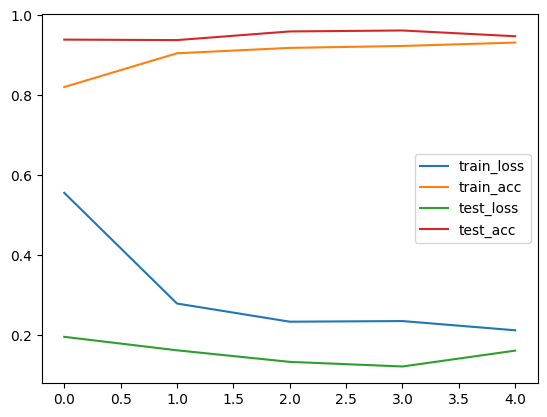

In [33]:
df = pd.DataFrame(history)
df.plot()

it is beautiful. There is no trace of overfitting or underfitting.Both train_loss and test_loss curves are pretty close to each other and so are train_acc and test_acc

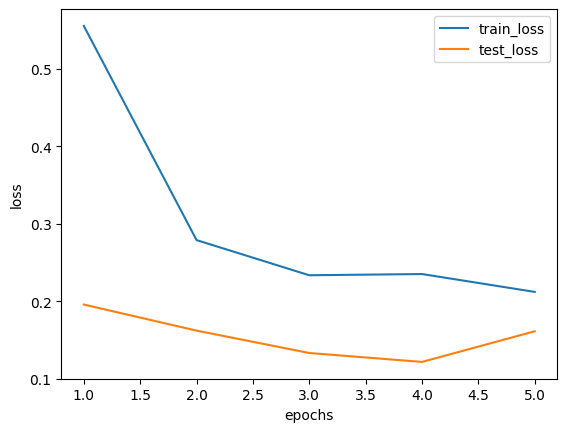

In [34]:
plt.plot(np.arange(1,len(history['train_loss'])+1),history['train_loss'],label='train_loss')
plt.plot(np.arange(1,len(history['test_loss'])+1),history['test_loss'],label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()

plt.show()

# 5.Validate the model on our test data


## goals:
1. access images from test_dir and choose 9 images randomly for the model to predict on.
2. convert them into PIL images. transform their size, shape, datatype and device
3. pass them into the model
4. get their labels and pred_probs(using torch.softmax).
5. plot them on maplotlib with title being the predicted_class_names and predicted probabilities.

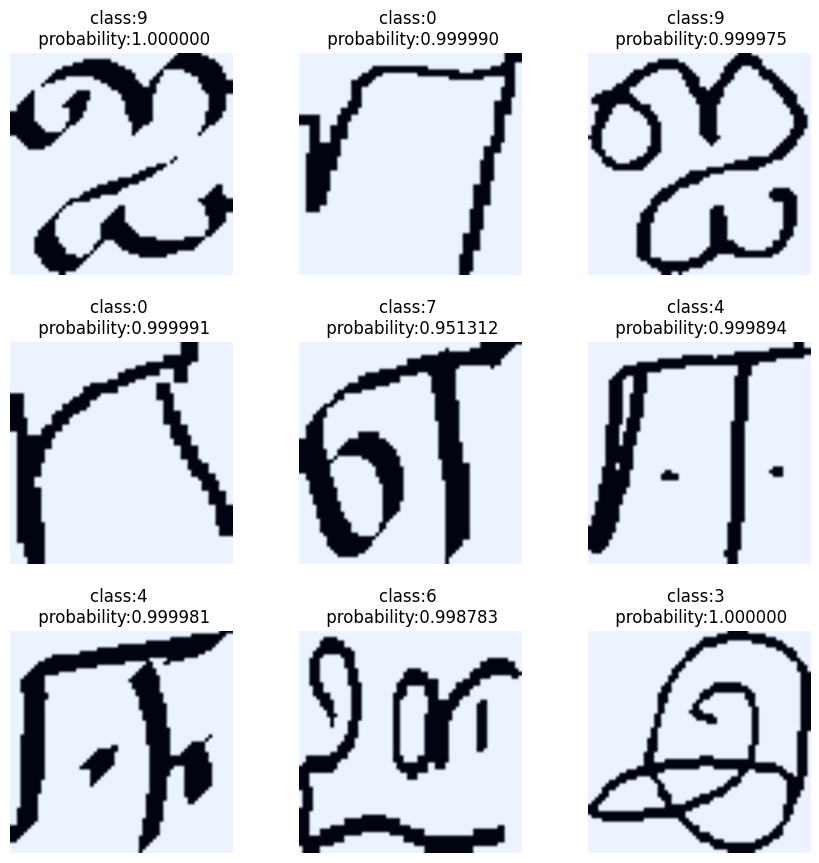

In [35]:
# getting 9 random images from test_dir
image_paths = np.random.choice(list(Path(test_dir).glob('*/*.bmp')),9)

# transform its size,shape and datatype and device to suit the model
auto_transform = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

# adjusting the plots
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
for i,image_path in enumerate(image_paths):

  # get the image
  image = Image.open(image_path)

  # apply augmentation(auto transform)
  image = auto_transform(image)

  # add an extra dimension for the batch for the model to accept
  image = torch.unsqueeze(image,dim=0)

  # put the image in the same device as the model was trained in
  image = image.to(device)

  # prediction
  model.eval()
  with torch.inference_mode():
    pred = model(image).argmax(dim=1)
    pred_prob = torch.max(torch.softmax(model(image),dim=1))

  # plotting them all
  plt.subplot(3,3,i+1)
  image = image.squeeze(dim=0)

  # normalizing or min-max scaling to get the values between 0 and 1.
  min = torch.min(image)
  max = torch.max(image)

  scaled_image = image/max

  if min != max:
    image = (image - min)/(max-min)
  else:
    image = scaled_image
  plt.imshow(image.permute(1,2,0).to('cpu'))
  plt.title('class:{} \n probability:{:3f}'.format(class_names[pred],pred_prob))
  plt.axis('off')

plt.show()




## Fine-tune this model

In [40]:
import torch
import torchvision
import optuna
import time
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from going_modular.going_modular import engine


device = 'cuda' if torch.cuda.is_available() else 'cpu'

def create_model(trial):
    # Suggest values of the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freezing all the layers by setting the gradient non-updatable
    for param in model.features.parameters():
        param.requires_grad = False

    # Updating the output layer of our model to the custom-data we have (assuming len(class_names) is defined)
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout_rate, inplace=True),  # Use the suggested dropout rate
        torch.nn.Linear(in_features=1408, out_features=len(class_names))
    ).to(device)

    return model, lr

def objective(trial):
    model, lr = create_model(trial)

    # Define loss function and optimizer
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    # Train the model
    history = engine.train(model=model,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           epochs=5,
                           device=device)

    # Calculate the validation accuracy of the last epoch
    val_accuracy = history['test_acc'][-1]

    return val_accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best parameters and the best score
print(f'Best parameters found: {study.best_params}')
print(f'Best validation accuracy: {study.best_value:.2f}')

# Train the best model on the entire training set with the best hyperparameters
best_trial = study.best_trial
best_model, best_lr = create_model(best_trial)
best_optimizer = Adam(best_model.parameters(), lr=best_lr)
best_loss_fn = CrossEntropyLoss()

start_time = time.perf_counter()
history = engine.train(model=best_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=best_loss_fn,
                       optimizer=best_optimizer,
                       epochs=5,
                       device=device)
end_time = time.perf_counter()

print(f'Total Running Time: {end_time - start_time:.2f} seconds')


[I 2024-06-03 06:17:46,662] A new study created in memory with name: no-name-c7053163-ebed-4eaf-869e-c4d927014d44


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1077 | train_acc: 0.7077 | test_loss: 0.9590 | test_acc: 0.8389
Epoch: 2 | train_loss: 1.9414 | train_acc: 0.7998 | test_loss: 0.6866 | test_acc: 0.8822
Epoch: 3 | train_loss: 1.7960 | train_acc: 0.8312 | test_loss: 0.4898 | test_acc: 0.9303
Epoch: 4 | train_loss: 1.8513 | train_acc: 0.8460 | test_loss: 0.8067 | test_acc: 0.8954


[I 2024-06-03 06:19:45,280] Trial 0 finished with value: 0.9387019230769231 and parameters: {'lr': 0.06269776580850943, 'dropout_rate': 0.4939625814328815}. Best is trial 0 with value: 0.9387019230769231.


Epoch: 5 | train_loss: 1.9458 | train_acc: 0.8543 | test_loss: 0.5927 | test_acc: 0.9387


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7484 | train_acc: 0.7498 | test_loss: 0.5435 | test_acc: 0.9159
Epoch: 2 | train_loss: 1.2967 | train_acc: 0.8732 | test_loss: 1.3784 | test_acc: 0.8918
Epoch: 3 | train_loss: 1.7474 | train_acc: 0.8674 | test_loss: 0.9480 | test_acc: 0.9219
Epoch: 4 | train_loss: 1.6036 | train_acc: 0.8863 | test_loss: 0.6857 | test_acc: 0.9435


[I 2024-06-03 06:21:56,800] Trial 1 finished with value: 0.9362980769230769 and parameters: {'lr': 0.09451308355267686, 'dropout_rate': 0.16684975852003886}. Best is trial 0 with value: 0.9387019230769231.


Epoch: 5 | train_loss: 1.3946 | train_acc: 0.9028 | test_loss: 0.8124 | test_acc: 0.9363


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3042 | train_acc: 0.7527 | test_loss: 0.8376 | test_acc: 0.8690
Epoch: 2 | train_loss: 0.8231 | train_acc: 0.8588 | test_loss: 0.3404 | test_acc: 0.9363
Epoch: 3 | train_loss: 0.7744 | train_acc: 0.8817 | test_loss: 0.7279 | test_acc: 0.8702
Epoch: 4 | train_loss: 0.7209 | train_acc: 0.8941 | test_loss: 0.9158 | test_acc: 0.9075


[I 2024-06-03 06:23:52,796] Trial 2 finished with value: 0.9435096153846154 and parameters: {'lr': 0.04758744951817628, 'dropout_rate': 0.24367529419717437}. Best is trial 2 with value: 0.9435096153846154.


Epoch: 5 | train_loss: 0.7995 | train_acc: 0.8985 | test_loss: 0.3632 | test_acc: 0.9435


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5954 | train_acc: 0.7243 | test_loss: 0.9411 | test_acc: 0.9014
Epoch: 2 | train_loss: 2.1859 | train_acc: 0.8248 | test_loss: 0.8450 | test_acc: 0.8978
Epoch: 3 | train_loss: 2.4190 | train_acc: 0.8357 | test_loss: 0.7530 | test_acc: 0.9291
Epoch: 4 | train_loss: 1.9462 | train_acc: 0.8637 | test_loss: 0.6391 | test_acc: 0.9507


[I 2024-06-03 06:25:56,057] Trial 3 finished with value: 0.9182692307692307 and parameters: {'lr': 0.08854097666191993, 'dropout_rate': 0.4198581171476572}. Best is trial 2 with value: 0.9435096153846154.


Epoch: 5 | train_loss: 2.6161 | train_acc: 0.8553 | test_loss: 1.0339 | test_acc: 0.9183


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1159 | train_acc: 0.7514 | test_loss: 0.7747 | test_acc: 0.8906
Epoch: 2 | train_loss: 1.6827 | train_acc: 0.8424 | test_loss: 0.7898 | test_acc: 0.9195
Epoch: 3 | train_loss: 1.5716 | train_acc: 0.8692 | test_loss: 1.2778 | test_acc: 0.8798
Epoch: 4 | train_loss: 1.6580 | train_acc: 0.8784 | test_loss: 0.9604 | test_acc: 0.9375


[I 2024-06-03 06:27:52,110] Trial 4 finished with value: 0.9423076923076923 and parameters: {'lr': 0.08446071238378754, 'dropout_rate': 0.2794080182474431}. Best is trial 2 with value: 0.9435096153846154.


Epoch: 5 | train_loss: 1.6725 | train_acc: 0.8801 | test_loss: 0.6902 | test_acc: 0.9423


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4437 | train_acc: 0.7567 | test_loss: 0.2303 | test_acc: 0.9399
Epoch: 2 | train_loss: 0.7821 | train_acc: 0.8607 | test_loss: 0.5647 | test_acc: 0.9207
Epoch: 3 | train_loss: 0.8608 | train_acc: 0.8756 | test_loss: 0.3620 | test_acc: 0.9423
Epoch: 4 | train_loss: 0.7501 | train_acc: 0.8962 | test_loss: 0.6272 | test_acc: 0.9207


[I 2024-06-03 06:29:54,195] Trial 5 finished with value: 0.9387019230769231 and parameters: {'lr': 0.0503737601459158, 'dropout_rate': 0.18399711304931363}. Best is trial 2 with value: 0.9435096153846154.


Epoch: 5 | train_loss: 0.7756 | train_acc: 0.8981 | test_loss: 0.4643 | test_acc: 0.9387


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2221 | train_acc: 0.7475 | test_loss: 0.5470 | test_acc: 0.9002
Epoch: 2 | train_loss: 0.9037 | train_acc: 0.8486 | test_loss: 0.3731 | test_acc: 0.9315
Epoch: 3 | train_loss: 0.8108 | train_acc: 0.8772 | test_loss: 0.4420 | test_acc: 0.9231
Epoch: 4 | train_loss: 0.8611 | train_acc: 0.8751 | test_loss: 0.5066 | test_acc: 0.9255


[I 2024-06-03 06:31:51,701] Trial 6 finished with value: 0.9495192307692307 and parameters: {'lr': 0.04235125605975773, 'dropout_rate': 0.30076567481558014}. Best is trial 6 with value: 0.9495192307692307.


Epoch: 5 | train_loss: 0.7775 | train_acc: 0.8888 | test_loss: 0.2915 | test_acc: 0.9495


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7063 | train_acc: 0.7817 | test_loss: 0.2339 | test_acc: 0.9291
Epoch: 2 | train_loss: 0.3859 | train_acc: 0.8806 | test_loss: 0.1857 | test_acc: 0.9111
Epoch: 3 | train_loss: 0.3716 | train_acc: 0.8912 | test_loss: 0.1827 | test_acc: 0.9519
Epoch: 4 | train_loss: 0.3449 | train_acc: 0.9121 | test_loss: 0.2641 | test_acc: 0.9291


[I 2024-06-03 06:33:48,507] Trial 7 finished with value: 0.9543269230769231 and parameters: {'lr': 0.020414520128402718, 'dropout_rate': 0.18620996239658663}. Best is trial 7 with value: 0.9543269230769231.


Epoch: 5 | train_loss: 0.3214 | train_acc: 0.9183 | test_loss: 0.1831 | test_acc: 0.9543


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8890 | train_acc: 0.7643 | test_loss: 0.5911 | test_acc: 0.9135
Epoch: 2 | train_loss: 1.1876 | train_acc: 0.8650 | test_loss: 0.7129 | test_acc: 0.9135
Epoch: 3 | train_loss: 1.4624 | train_acc: 0.8606 | test_loss: 1.2702 | test_acc: 0.9002
Epoch: 4 | train_loss: 1.2785 | train_acc: 0.8882 | test_loss: 0.7192 | test_acc: 0.9279


[I 2024-06-03 06:35:42,868] Trial 8 finished with value: 0.9459134615384616 and parameters: {'lr': 0.0763882919997609, 'dropout_rate': 0.13714956250460686}. Best is trial 7 with value: 0.9543269230769231.


Epoch: 5 | train_loss: 1.1216 | train_acc: 0.9061 | test_loss: 0.6552 | test_acc: 0.9459


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2057 | train_acc: 0.7457 | test_loss: 0.3644 | test_acc: 0.9099
Epoch: 2 | train_loss: 0.9560 | train_acc: 0.8429 | test_loss: 0.3615 | test_acc: 0.9207
Epoch: 3 | train_loss: 0.8737 | train_acc: 0.8585 | test_loss: 0.4155 | test_acc: 0.9291
Epoch: 4 | train_loss: 0.9708 | train_acc: 0.8737 | test_loss: 0.3385 | test_acc: 0.9399


[I 2024-06-03 06:37:42,232] Trial 9 finished with value: 0.9314903846153846 and parameters: {'lr': 0.04059088926171012, 'dropout_rate': 0.3795029671196394}. Best is trial 7 with value: 0.9543269230769231.


Epoch: 5 | train_loss: 0.9328 | train_acc: 0.8739 | test_loss: 0.6266 | test_acc: 0.9315
Best parameters found: {'lr': 0.020414520128402718, 'dropout_rate': 0.18620996239658663}
Best validation accuracy: 0.95


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6652 | train_acc: 0.7907 | test_loss: 0.2443 | test_acc: 0.9171
Epoch: 2 | train_loss: 0.3943 | train_acc: 0.8764 | test_loss: 0.1621 | test_acc: 0.9495
Epoch: 3 | train_loss: 0.2857 | train_acc: 0.9124 | test_loss: 0.1988 | test_acc: 0.9387
Epoch: 4 | train_loss: 0.3035 | train_acc: 0.9105 | test_loss: 0.1377 | test_acc: 0.9543
Epoch: 5 | train_loss: 0.3416 | train_acc: 0.9170 | test_loss: 0.1198 | test_acc: 0.9615
Total Running Time: 139.96 seconds


## Experimenting with best parameters and increased epoch to 10 instead of 5.

In [41]:
best_trial = study.best_trial
best_model, best_lr = create_model(best_trial)
best_optimizer = Adam(best_model.parameters(), lr=best_lr)
best_loss_fn = CrossEntropyLoss()

start_time = time.perf_counter()
history = engine.train(model=best_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=best_loss_fn,
                       optimizer=best_optimizer,
                       epochs=10,
                       device=device)
end_time = time.perf_counter()

print(f'Total Running Time: {end_time - start_time:.2f} seconds')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6355 | train_acc: 0.7969 | test_loss: 0.1886 | test_acc: 0.9399
Epoch: 2 | train_loss: 0.3746 | train_acc: 0.8861 | test_loss: 0.1483 | test_acc: 0.9519
Epoch: 3 | train_loss: 0.3489 | train_acc: 0.9007 | test_loss: 0.1527 | test_acc: 0.9555
Epoch: 4 | train_loss: 0.3174 | train_acc: 0.9160 | test_loss: 0.2060 | test_acc: 0.9459
Epoch: 5 | train_loss: 0.3635 | train_acc: 0.9121 | test_loss: 0.2207 | test_acc: 0.9399
Epoch: 6 | train_loss: 0.3226 | train_acc: 0.9186 | test_loss: 0.1697 | test_acc: 0.9543
Epoch: 7 | train_loss: 0.3407 | train_acc: 0.9170 | test_loss: 0.1935 | test_acc: 0.9567
Epoch: 8 | train_loss: 0.2707 | train_acc: 0.9364 | test_loss: 0.1944 | test_acc: 0.9495
Epoch: 9 | train_loss: 0.3968 | train_acc: 0.9186 | test_loss: 0.2221 | test_acc: 0.9459
Epoch: 10 | train_loss: 0.3268 | train_acc: 0.9324 | test_loss: 0.2533 | test_acc: 0.9231
Total Running Time: 241.88 seconds


# Conclusion:
**Our SVD model seems to have given us the best test accuracy(98%) compared to a neural network based efficient_net_b2 model.**